In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


In [2]:
n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})


In [3]:
y = pd.Series(df["sales"].values, index=df["date"]).astype(float)

split = int(len(y) * 0.8)
train = y.iloc[:split]
test  = y.iloc[split:]


In [4]:
order = (2, 1, 2)
arima = ARIMA(train, order=order)
arima_fit = arima.fit()

arima_train_pred = arima_fit.fittedvalues
arima_test_pred  = arima_fit.forecast(steps=len(test))


c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
 

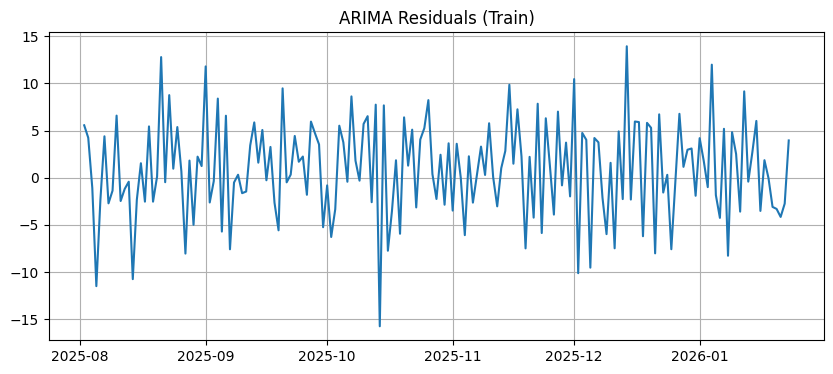

In [5]:
residuals_train = train.iloc[1:] - arima_train_pred.iloc[1:]

plt.figure(figsize=(10,4))
plt.plot(residuals_train)
plt.title("ARIMA Residuals (Train)")
plt.grid(True)
plt.show()


In [6]:
scaler = MinMaxScaler()
res_scaled = scaler.fit_transform(residuals_train.values.reshape(-1,1)).astype(np.float32)

LOOKBACK = 30

def make_sequences(arr_2d, lookback):
    X, y = [], []
    for i in range(lookback, len(arr_2d)):
        X.append(arr_2d[i-lookback:i, 0])
        y.append(arr_2d[i, 0])
    X = np.array(X, dtype=np.float32)[:, :, None]
    y = np.array(y, dtype=np.float32)[:, None]
    return X, y

X_train, y_train = make_sequences(res_scaled, LOOKBACK)


In [7]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dl = DataLoader(SeqDataset(X_train, y_train), batch_size=32, shuffle=True)


In [8]:
class ResidualLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = ResidualLSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [9]:
EPOCHS = 25
model.train()

for epoch in range(EPOCHS):
    losses = []
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss {np.mean(losses):.6f}")


Epoch 5 | Loss 0.037036
Epoch 10 | Loss 0.029459
Epoch 15 | Loss 0.028420
Epoch 20 | Loss 0.030052
Epoch 25 | Loss 0.030096


In [10]:
model.eval()

# preparar ventana inicial de residuales
window = res_scaled[-LOOKBACK:].copy()
res_preds = []

for _ in range(len(test)):
    X = torch.from_numpy(window.reshape(1, LOOKBACK, 1)).float().to(device)
    with torch.no_grad():
        res_hat = model(X).cpu().numpy()[0,0]
    res_preds.append(res_hat)
    window = np.vstack([window[1:], [[res_hat]]])

res_preds = scaler.inverse_transform(np.array(res_preds).reshape(-1,1)).reshape(-1)

final_pred = arima_test_pred.values + res_preds


In [11]:
mae  = mean_absolute_error(test.values, final_pred)
rmse = np.sqrt(mean_squared_error(test.values, final_pred))
mape = np.mean(np.abs((test.values - final_pred) / np.maximum(test.values, 1e-8))) * 100

print("Hybrid ARIMA–LSTM Metrics")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


Hybrid ARIMA–LSTM Metrics
MAE  : 9.90
RMSE : 11.96
MAPE : 11.02%


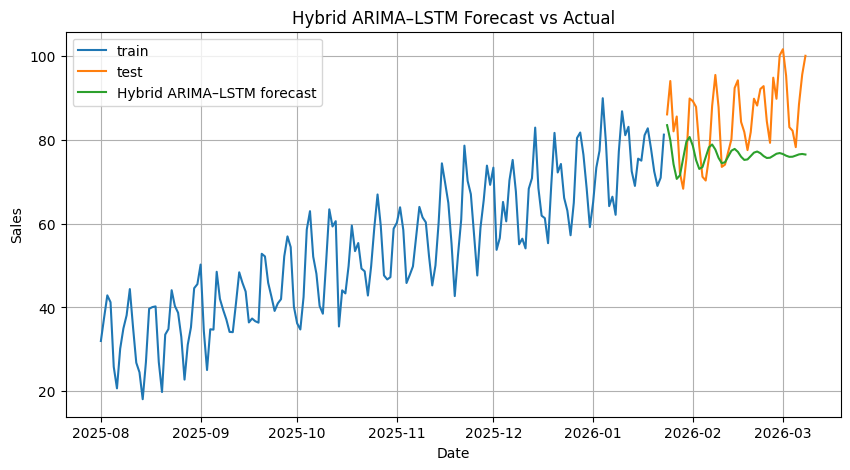

In [12]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train.values, label="train")
plt.plot(test.index, test.values, label="test")
plt.plot(test.index, final_pred, label="Hybrid ARIMA–LSTM forecast")
plt.title("Hybrid ARIMA–LSTM Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.grid(True)
plt.show()
